# Preprocessing Module

In [1]:
### Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

import ipyleaflet as ipy

from pyspark import SparkContext
import pyspark.sql.functions as F
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import Window as W
from pyspark.sql.types import *

import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import pickle

Matplotlib created a temporary cache directory at /tmp/matplotlib-wzysdon9 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
## Start Spark context
total_nodes = 40
memory_per_node = 200

driver_memory = f"{memory_per_node}g"
executor_memory = f"{int(memory_per_node/total_nodes)}g"
n_executors = total_nodes - 1
print(f"Driver memory: {driver_memory}\nExecutor memory: {executor_memory}\nNumber of executors: {n_executors}\n")
try:
    print("Initializing SparkContext")
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()
except:
    print("Starting new SparkContext")
    sc.stop()
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()
print(sc)

# Start SQL Context
sqlContext = SQLContext(sc)

sc.getActiveSession()

Driver memory: 200g
Executor memory: 5g
Number of executors: 39

Initializing SparkContext


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
%%time
### Load datasets
df_type = 30
max_timestamps = 24*60/30
conversion = (60/30) * (1/1000)
timestamp_col = "datetime"
df = sqlContext.read.load("30min.parquet")
df = df.cache()

### Open parquet files as Spark Data Frame
df_count = df.count()

# metadata
meta_filename = "metadata.csv"
df_meta = sc.read.csv(meta_filename, inferSchema=True, header=True)
df_meta_count = df_meta.count()

### Since metadata table is so small, convert to Pandas
df_meta = df_meta.toPandas()

CPU times: user 110 ms, sys: 46.1 ms, total: 156 ms
Wall time: 56.5 s


In [4]:
## View data on df
print(df_count)

2644013376


## Filter for only ss_ids with kwp values within the IQR range

In [5]:
%%time
### Calculate the power kwp cutoffs

high_kwp_cutoff = df_meta["kwp"].quantile(0.75)
low_kwp_cutoff = df_meta["kwp"].quantile(0.25)

print("Filtering for systems where kwp <=", high_kwp_cutoff, "and kwp >=", low_kwp_cutoff)

ss_id_list = list(df_meta[(df_meta["kwp"] <= high_kwp_cutoff) & (df_meta["kwp"] >= low_kwp_cutoff)]["ss_id"])
# df.unpersist()
df = df.where(F.col("ss_id").isin(ss_id_list)).cache()

print(df.count())

Filtering for systems where kwp <= 3.42 and kwp >= 2.28
1355430864
CPU times: user 853 ms, sys: 218 ms, total: 1.07 s
Wall time: 46.5 s


## Define the basis of sinusoids

Shape of the basis matrix: (21, 48)

The following sinusoids are used to model the curves:
0.2041241452319315/sqrt(2) * cos(0*x)
0.2041241452319315 * cos(1*x)
0.2041241452319315 * sin(1*x)
0.2041241452319315 * cos(2*x)
0.2041241452319315 * sin(2*x)
0.2041241452319315 * cos(3*x)
0.2041241452319315 * sin(3*x)
0.2041241452319315 * cos(4*x)
0.2041241452319315 * sin(4*x)
0.2041241452319315 * cos(5*x)
0.2041241452319315 * sin(5*x)
0.2041241452319315 * cos(6*x)
0.2041241452319315 * sin(6*x)
0.2041241452319315 * cos(7*x)
0.2041241452319315 * sin(7*x)
0.2041241452319315 * cos(8*x)
0.2041241452319315 * sin(8*x)
0.2041241452319315 * cos(9*x)
0.2041241452319315 * sin(9*x)
0.2041241452319315 * cos(10*x)
0.2041241452319315 * sin(10*x)


Plotting basis sinusoids (The more sinusoids, the busier the plot)

CPU times: user 14.4 ms, sys: 3.74 ms, total: 18.1 ms
Wall time: 17.6 ms


Text(0.5, 1.0, 'Plotting the first 5 sinusoids')

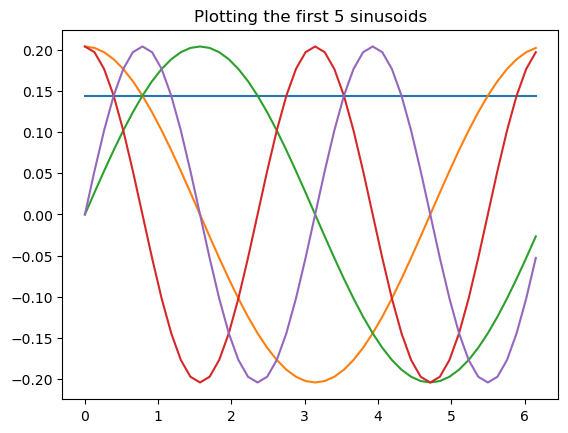

In [6]:
%%time
### Define necessary constants to set up the basis
n_sinusoid_pairs = 10 #--> Adds a pair of sinusoids at increasing frequencies (for 1 + 2*n_sinusoid_pairs total)
max_timestamps = 48 # The number of 30-min intervals in a day

### Define orthonormal basis (sinusoids for Fourier Transform)
step = 2*np.pi/max_timestamps
x = np.arange(0, 2*np.pi, step)
const = np.sqrt(step/np.pi)

basis = []
basis.append(np.array(np.cos(0*x)) * const/np.sqrt(2))
for i in range(0, n_sinusoid_pairs):
    i += 1
    basis.append(np.array(np.cos(i*x))*const)
    basis.append(np.array(np.sin(i*x))*const)
    
basis = np.array(basis)
print(f"Shape of the basis matrix: {basis.shape}")
print()
print("The following sinusoids are used to model the curves:")
print(f"{const}/sqrt(2) * cos(0*x)")
for i in np.arange(1, n_sinusoid_pairs+1):
    print(f"{const} * cos({i}*x)")
    print(f"{const} * sin({i}*x)")
print()
        
print("\nPlotting basis sinusoids (The more sinusoids, the busier the plot)\n")

# for i in range(0, basis.shape[0]):
for i in range(0, 5):
    plt.plot(x, basis[i])
plt.title("Plotting the first 5 sinusoids")

## Collect the timestamps for each ss_id and date group into a list

* Only keep groupings that have all 48 timestamps and no NULLS
* Project the power values onto the sinusoidal basis

In [7]:
%%time
### Preprocessing for eigenvalue decomposition
# stamp_date: Date as extracted from the timestamp column to index data
# time_i: Index to sort the timestamps
# power_kW: Converting generation_wh which is in Watts*(30 min) to kW

### Preprocess the df
# Collect power_kW for each stamp_date/ss_id pairing ordered by timestamp
# Limit results to only rows with all timestamps and no null generation values
df = df.dropna() \
       .select("generation_wh", "ss_id", F.col(timestamp_col).alias("timestamp")) \
       .withColumn("stamp_date", F.to_date("timestamp")) \
       .withColumn("time_i", (F.hour("timestamp") * F.lit(60) + F.minute("timestamp")) / df_type) \
       .withColumn("power_kW", (F.col("generation_wh") * F.lit(conversion)).alias("power_kW")) \
       .orderBy(["ss_id", "stamp_date", "time_i"], ascending=True) \
       .groupBy("ss_id", "stamp_date") \
       .agg(F.collect_list(F.col("power_kW")).alias("power_values")) \
       .where(F.size(F.col("power_values")) == max_timestamps) \
       .withColumn("id", F.monotonically_increasing_id()) \
       .select("id", "ss_id", "stamp_date", "power_values")

### Project the points onto the sinusoidal basis
df = df.rdd.map(lambda a: ((a[0], a[1], a[2], a[3]), np.nan_to_num(np.array(a[3])))) \
           .map(lambda b: (b[0], np.dot(b[1], basis.T))) \
           .cache()

### Reformat the outputs
df = df.map(lambda a: (a[0][0], a[0][1], a[0][2], a[0][3], a[1].tolist()))

CPU times: user 53.8 ms, sys: 26.5 ms, total: 80.3 ms
Wall time: 2min 33s


Coefficient indices for the ss_id/date pairings in descending order of coefficient magnitude
<built-in function id>, 2405, 2010-11-23: [ 1  3  0  5  6  4 17 19  7  8 15  2 13  9 16 14 11 10 18 12 20]
<built-in function id>, 2428, 2011-08-08: [ 1  0  3  2  4  9 11 13 15  8 19 18 14 20 10 12  7  6  5 16 17]
<built-in function id>, 2405, 2011-06-06: [ 1  0  3  7  2  9  4 16 13 18  5 17  6 11 19 12  8 14 15 20 10]
<built-in function id>, 2428, 2017-08-20: [ 1  0  3 12  7 10 14  9  8  2 16  4 11 19 18 15 20 17  5  6 13]
CPU times: user 209 ms, sys: 14.2 ms, total: 223 ms
Wall time: 18 s


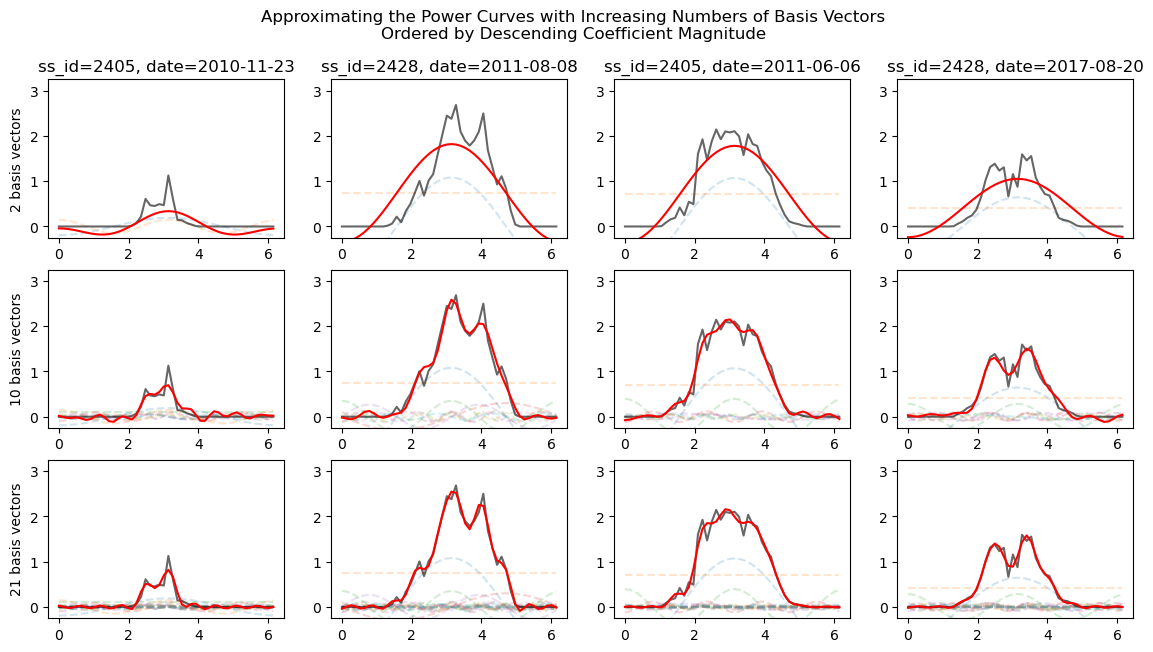

In [8]:
%%time
### Current variables --> ss_id, stamp_date, power_kW_values, coefficients
# Coefficients for reconstructing from the sinusoidal basis

### Compare the projections to the original
result = df.take(100)
result_ind = [0, 60, 5, 95]
n_vectors = [2, int(basis.shape[0]/2), basis.shape[0]]

fig, axes = plt.subplots(len(n_vectors), len(result_ind), figsize = (14,7))
plt.suptitle("Approximating the Power Curves with Increasing Numbers of Basis Vectors\nOrdered by Descending Coefficient Magnitude")
print("Coefficient indices for the ss_id/date pairings in descending order of coefficient magnitude")
for ax_i,n_vector in enumerate(n_vectors):
    for ax_j,n in enumerate(result_ind):
        ss_id = result[n][1]
        date = result[n][2]
        values = result[n][3]
        coeffs = np.array(result[n][4])
        
        # Sort basis vectors by coefficient to plot most important components
        coeffs_ind = np.argsort(np.absolute(coeffs))[::-1]
        coeffs = coeffs[coeffs_ind][:n_vector]
        basis_plot = basis[coeffs_ind, :]#[:n_vector,:]

        # Plot the projections
        projections = []
        for i,(coeff,vec) in enumerate(zip(coeffs, basis_plot)):
            projection = coeff * vec
            projections.append(projection)

            axes[ax_i, ax_j].plot(x, projection, linestyle="--", alpha=0.2)
            
        # Plot the mean vector and the sum of the projections
        projections = np.array(projections)
        mean_vec = np.sum(projections, axis=0)
        
        if ax_i==0:
            axes[ax_i, ax_j].set_title(f"ss_id={ss_id}, date={date}")
            print(f"{id}, {ss_id}, {date}: {coeffs_ind}")
        if ax_j==0:
            axes[ax_i, ax_j].set_ylabel(f"{n_vector} basis vectors")

        axes[ax_i, ax_j].plot(x, values, color="black", alpha=0.6)
        axes[ax_i, ax_j].plot(x, mean_vec, color="red")
        axes[ax_i, ax_j].set_ylim([-0.25, 3.25])

In [9]:
### Add the reconstructions to the dataset
df = df.map(lambda a: ((a[0], a[1], a[2], a[3], a[4]), 
                        np.dot(np.array(a[4]), basis))) \
       .map(lambda b: (b[0][0], b[0][1], b[0][2], b[0][3], b[0][4], b[1].tolist())) 

+---+-----+----------+--------------------+--------------------+--------------------+
| id|ss_id|stamp_date|     power_kW_values|        coefficients|     reconstructions|
+---+-----+----------+--------------------+--------------------+--------------------+
|  0| 2405|2010-11-23|[0.0, 0.0, 0.0, 0...|[0.71520707971537...|[0.02524777981168...|
|  1| 2405|2010-12-04|[0.0, 0.0, 0.0, 0...|[0.0, 0.0, 0.0, 0...|[0.0, 0.0, 0.0, 0...|
|  2| 2405|2010-12-12|[0.0, 0.0, 0.0, 0...|[0.33681460003984...|[0.00371762809627...|
+---+-----+----------+--------------------+--------------------+--------------------+
only showing top 3 rows



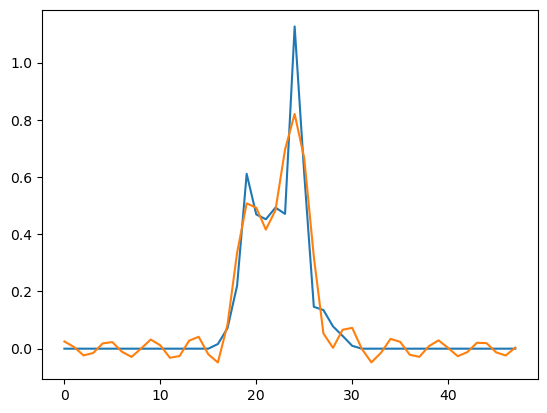

In [10]:
### Turn to DF temporarily for some visualizations
df2 = df.toDF(["id", "ss_id", "stamp_date", "power_kW_values", "coefficients", "reconstructions"])

df2.show(3)

test_power = np.array(df2.select("power_kW_values").take(1)[0][0])
test_recon = np.array(df2.select("reconstructions").take(1)[0][0])

x = np.array([i for i in np.arange(0, 48)])
plt.plot(x, test_power)
plt.plot(x, test_recon)

In [11]:
%%time
### Comparing the mean generation curve with the mean reconstruction curve
df_power = df2.select("id", F.posexplode("power_kW_values")) \
              .groupBy("pos") \
              .agg(F.mean("col").alias("mean_power"),
                   F.std("col").alias("std_power")) \
              .toPandas()

df_recon = df2.select("id", F.posexplode("reconstructions")) \
              .groupBy("pos") \
              .agg(F.mean("col").alias("mean_recon"),
                   F.std("col").alias("std_recon")) \
              .toPandas()


CPU times: user 16.1 ms, sys: 26 ms, total: 42.1 ms
Wall time: 1min 43s


CPU times: user 64.9 ms, sys: 3.39 ms, total: 68.3 ms
Wall time: 69.7 ms


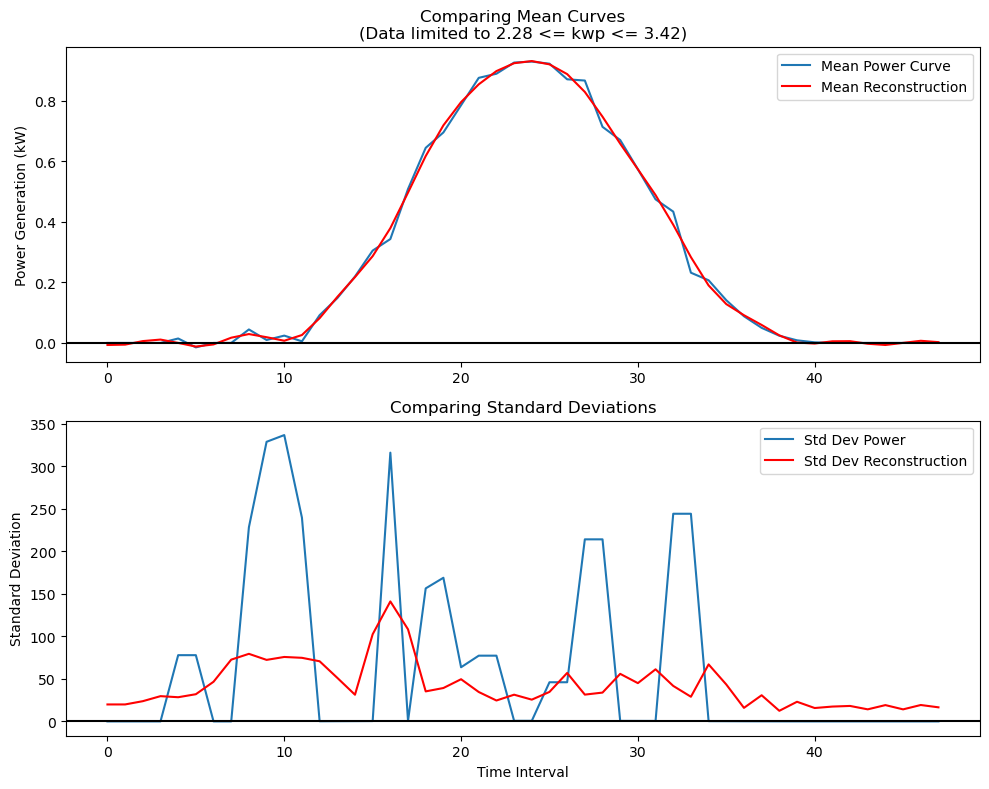

In [12]:
%%time
### Plotting
df2_power = df_power.sort_values("pos")
df2_recon = df_recon.sort_values("pos")

fig,ax = plt.subplots(2, 1, figsize=(10,8))
ax[0].plot(df2_power["pos"], df2_power["mean_power"], label="Mean Power Curve")
ax[0].plot(df2_recon["pos"], df2_recon["mean_recon"], color="r", label="Mean Reconstruction")
ax[0].axhline(0, 0, 48, c="k")
ax[0].set_title("Comparing Mean Curves\n(Data limited to 2.28 <= kwp <= 3.42)")
ax[0].set_ylabel("Power Generation (kW)")
ax[0].legend()
# ax[0].set_ylim([-5, 600])
ax[1].plot(df2_power["pos"], df2_power["std_power"], label="Std Dev Power")
ax[1].plot(df2_recon["pos"], df2_recon["std_recon"], color="r", label="Std Dev Reconstruction")
ax[1].legend()
ax[1].set(title="Comparing Standard Deviations", ylabel="Standard Deviation", xlabel="Time Interval")
ax[1].axhline(0, 0, 48, c="k")

plt.tight_layout()

# PCA for both power and reconstructions

In [13]:
### Define function to get covariance and other related stats
def compute_covariance_matrix(df, col):
    ### Map steps --> Incorporating NaN handling
    # 1: Create an array and insert 1 into element 0 (vec_length being max_timestamps + 1)
    # 2: Get the outer product of the array and indices of non-null values (as 1)
    # 3: Reduce to get two matrices: matrix sum and non-null indices
    sums_nonNullCounts =  df.select(col) \
                            .rdd.map(lambda a: (np.array([1] + a[0]))) \
                                .map(lambda b: (np.outer(b, b), 1-np.outer(b,b))) \
                                .reduce(lambda c1, c2: (np.nansum(np.dstack((c1[0], c2[0])), axis=2), c1[1] + c2[1])) \

    # S: Sum, NNC: Non-Null Count
    S, N = sums_nonNullCounts

    # Get E(x) --> Ex = Mean of df2_S[0, 1:]
    S_x = S[0, 1:]
    NNC_x = N[0, 1:]
    Ex = S_x/NNC_x

    # Get E(xxT) --> ExxT = Mean of df2_S[1:,1:]
    S_xxT = S[1:, 1:]
    NNC_xxT = N[1:, 1:]
    ExxT = S_xxT/NNC_xxT

    # Get covariance
    cov = ExxT - np.outer(Ex, Ex)

    output = [cov, Ex]

    return output

def get_ordered_eigval_eigvec(cov):
    ### Extract the eigenvalues and eigenvectors, then output them ordered by eigenvalue magnitude
    eigval, eigvec = np.linalg.eig(cov)
    eigval_ind = np.argsort(np.absolute(eigval))[::-1]
    output = [eigval[eigval_ind], eigvec[eigval_ind]]
    
    return output

def plot_explained_variance(eigval, max_num = None):
    ### View the amount of variance explained by each eigvenvector
    if max_num is None:
        max_num = len(eigval)
    total_var = np.sum(np.absolute(eigval))
    explained_var = []
    for i in range(0,max_num):
        explained_var.append((sum(np.absolute(eigval[:i])) / total_var) * 100)
        print(f"Up to vector {i}: {explained_var[i]}")
        
    plt.plot(range(0,max_num), explained_var)
    plt.title("Variance Explained by Eigenvectors")
    plt.xlabel("Number of Eigenvectors")
    plt.ylabel("% of Variance Explained")
    plt.show()


In [14]:
### PCA to visualize variance
col = "reconstructions"
### Calculate covariance matrix
recon_cov, recon_colMeans = compute_covariance_matrix(df2, col)
### Perform eigenvalue decomposition to get eigenvalues/eigenvectors of covariance matrix
recon_eigval, recon_eigvec = get_ordered_eigval_eigvec(recon_cov)

### PCA on coefficients to visualize them
col = "power_kW_values"
### Calculate covariance matrix
cov, colMeans = compute_covariance_matrix(df2, col)
### Perform eigenvalue decomposition to get eigenvalues/eigenvectors of covariance matrix
eigval, eigvec = get_ordered_eigval_eigvec(cov)

Variance Explained From Power Decomposition
Up to vector 0: 0.0
Up to vector 1: 38.83064816010436
Up to vector 2: 74.00662810740837
Up to vector 3: 85.45427083028153
Up to vector 4: 92.4662294882607
Up to vector 5: 96.7978217962232
Up to vector 6: 97.9238456142454
Up to vector 7: 98.7970544504356
Up to vector 8: 99.21239574201086
Up to vector 9: 99.60923466849547

Variance Explained From Reconstruction Decomposition
Up to vector 0: 0.0
Up to vector 1: 93.33648044707475
Up to vector 2: 98.2881834123083
Up to vector 3: 98.74549535047038
Up to vector 4: 99.18463627165319
Up to vector 5: 99.28507515502419
Up to vector 6: 99.37938967462941
Up to vector 7: 99.43068928238972
Up to vector 8: 99.4813753975753
Up to vector 9: 99.5283792517487



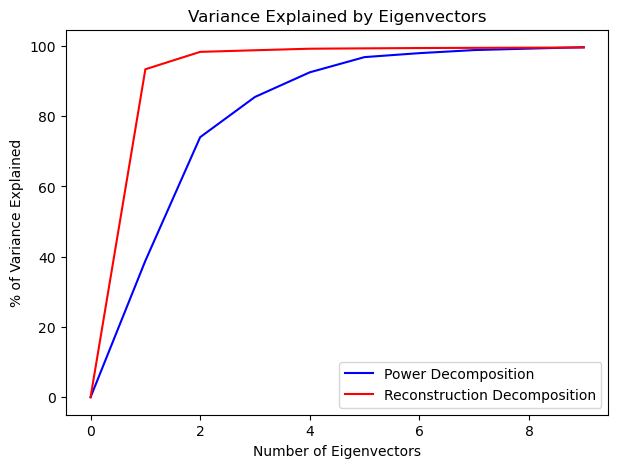

In [15]:
### Comparing variance explained
max_num=10
fig, axes = plt.subplots(1,1, figsize=(7,5))
eig = [eigval, recon_eigval]
labels = ["Power Decomposition", "Reconstruction Decomposition"]
colors = ["b", "r"]

# fig,ax = plt.subplots(1,1, figsize=(6,5))
for j, eigval_i in enumerate(eig):
    total_var = np.sum(np.absolute(eigval_i))
    explained_var = []
    print("Variance Explained From", labels[j])
    for i in range(0,max_num):
        explained_var.append((sum(np.absolute(eigval_i[:i])) / total_var) * 100)
        print(f"Up to vector {i}: {explained_var[i]}")
    print()
    plt.plot(range(0,max_num), explained_var, label=labels[j], color=colors[j])
    plt.title("Variance Explained by Eigenvectors")
    plt.xlabel("Number of Eigenvectors")
    plt.ylabel("% of Variance Explained")
plt.legend()
plt.show()

In [16]:
%%time
### Get a representation for each data point along the 2 principal components
# input: id, ss_id, stamp_date, power_kW_values, coefficients, reconstructions
# output: id, ss_id, stamp_date, power_kW_values, coefficients, reconstructions, recon(pc, pc1, pc2)
df2 = df.map(lambda a: ((a[0], a[1], a[2], a[3], a[4], a[5]), np.nan_to_num(np.array(a[5])).reshape(1, len(a[5])), 2)) \
         .map(lambda b: (b[0], np.dot(b[1], recon_eigvec[0:2].T))) \
         .map(lambda b: (b[0][0], b[0][1], b[0][2], b[0][3], b[0][4], b[0][5], b[1][0].tolist(), float(b[1][0][0]), float(b[1][0][1]))) \
         .map(lambda a: ((a[0], a[1], a[2], a[3], a[4], a[5], a[6], a[7], a[8]), np.nan_to_num(np.array(a[5])).reshape(1, len(a[5])), 2)) \
         .map(lambda b: (b[0], np.dot(b[1], eigvec[0:2].T))) \
         .map(lambda b: (b[0][0], b[0][1], b[0][2], b[0][3], b[0][4], b[0][5], b[0][6], b[0][7], b[0][8], b[1][0].tolist(), float(b[1][0][0]), float(b[1][0][1]))) \
         .toDF(["id", "ss_id", "stamp_date", "power_kW_values", "coefficients", "reconstructions", "recon_PC", "recon_PC1", "recon_PC2", "power_PC", "power_PC1", "power_PC2"])

CPU times: user 8.41 ms, sys: 762 µs, total: 9.17 ms
Wall time: 317 ms


In [19]:
df2.show(1)
df2.count()

+---+-----+----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
| id|ss_id|stamp_date|     power_kW_values|        coefficients|     reconstructions|            recon_PC|         recon_PC1|           recon_PC2|            power_PC|           power_PC1|           power_PC2|
+---+-----+----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|  0| 2405|2010-11-23|[0.0, 0.0, 0.0, 0...|[0.71520707971537...|[0.02524777981168...|[-0.2638811195496...|-0.263881119549691|-0.03329644242230784|[0.00374332849922...|0.003743328499225...|0.010155402836609791|
+---+-----+----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------

28190885

In [20]:
### Saving the new preprocessed df (More partitions is faster and less computationally expensive)
df2.repartition(10).write.mode("overwrite").parquet("preprocessed_df")

In [21]:
### Saving to a single file for convenience
df2.repartition(1).write.mode("overwrite").parquet("preprocessed_df_single")